In [94]:
import pandas as pd
import numpy as np
from sklearn import preprocessing 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import dvc.api
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder


In [95]:
# import necessary library
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing 
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import sklearn.utils
import dvc.api
# suppress warnings 
import warnings
warnings.simplefilter("ignore")

In [96]:
path = 'data/AdSmartABdata1.csv'
repo = '/home/michael/abtest-mlops'
version = 'v2'

data_url = dvc.api.get_url(
    path = path,
    repo = repo,
    rev=version
    )

In [97]:
df = pd.read_csv(data_url)

In [98]:
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [99]:
df['date']=pd.to_datetime(df['date'])
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [100]:
# Create a Day of Week feature
df['day_of_week'] = df['date'].dt.day_name()
# Remove Date column
del df['date']
df.head()

,auction_id,experiment,hour,device_make,platform_os,browser,yes,no,day_of_week
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,8,Generic Smartphone,6,Chrome Mobile,0,0,Friday
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,10,Generic Smartphone,6,Chrome Mobile,0,0,Tuesday
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2,E5823,6,Chrome Mobile WebView,0,1,Sunday
3,00187412-2932-4542-a8ef-3633901c98d9,control,15,Samsung SM-A705FN,6,Facebook,0,0,Friday
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,15,Generic Smartphone,6,Chrome Mobile,0,0,Friday


In [101]:
ml_data = df.copy()

In [102]:
ml_data.head()

,auction_id,experiment,hour,device_make,platform_os,browser,yes,no,day_of_week
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,8,Generic Smartphone,6,Chrome Mobile,0,0,Friday
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,10,Generic Smartphone,6,Chrome Mobile,0,0,Tuesday
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2,E5823,6,Chrome Mobile WebView,0,1,Sunday
3,00187412-2932-4542-a8ef-3633901c98d9,control,15,Samsung SM-A705FN,6,Facebook,0,0,Friday
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,15,Generic Smartphone,6,Chrome Mobile,0,0,Friday


In [103]:
ord_enc = OrdinalEncoder()

In [104]:
ml_data['experiment']= ord_enc.fit_transform(ml_data[['experiment']])
ml_data['device_make']= ord_enc.fit_transform(ml_data[['device_make']])
ml_data['browser']= ord_enc.fit_transform(ml_data[['browser']])
ml_data['day_of_week']= ord_enc.fit_transform(ml_data[['day_of_week']])
ml_data.head()

,auction_id,experiment,hour,device_make,platform_os,browser,yes,no,day_of_week
0,0008ef63-77a7-448b-bd1e-075f42c55e39,1.0,8,46.0,6,2.0,0,0,0.0
1,000eabc5-17ce-4137-8efe-44734d914446,1.0,10,46.0,6,2.0,0,0,5.0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,1.0,2,29.0,6,3.0,0,1,3.0
3,00187412-2932-4542-a8ef-3633901c98d9,0.0,15,137.0,6,6.0,0,0,0.0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,0.0,15,46.0,6,2.0,0,0,0.0


In [105]:
# User who have answered the questioners 
ml_data =ml_data[np.logical_or(df['yes']==1,ml_data['no']==1)]
ml_data.shape

(1243, 9)

In [106]:
ml_data.head()

,auction_id,experiment,hour,device_make,platform_os,browser,yes,no,day_of_week
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,1.0,2,29.0,6,3.0,0,1,3.0
16,008aafdf-deef-4482-8fec-d98e3da054da,1.0,16,46.0,6,2.0,1,0,2.0
20,00a1384a-5118-4d1b-925b-6cdada50318d,1.0,8,46.0,6,2.0,0,1,1.0
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,0.0,4,114.0,6,6.0,1,0,6.0
27,00ebf4a8-060f-4b99-93ac-c62724399483,0.0,15,46.0,6,2.0,0,1,0.0


In [107]:
ml_data = ml_data.reset_index(drop=True)

In [108]:
ml_data.shape

(1243, 9)

In [109]:
# Droping the user id value
del ml_data['auction_id']

In [110]:
ml_data.head()

,experiment,hour,device_make,platform_os,browser,yes,no,day_of_week
0,1.0,2,29.0,6,3.0,0,1,3.0
1,1.0,16,46.0,6,2.0,1,0,2.0
2,1.0,8,46.0,6,2.0,0,1,1.0
3,0.0,4,114.0,6,6.0,1,0,6.0
4,0.0,15,46.0,6,2.0,0,1,0.0


In [111]:
# 
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler()
ml_data[:] = scaling.fit_transform(ml_data[:])
ml_data.head()

,experiment,hour,device_make,platform_os,browser,yes,no,day_of_week
0,1.0,0.086957,0.098485,1.0,0.153846,0.0,1.0,0.500000
1,1.0,0.695652,0.162879,1.0,0.076923,1.0,0.0,0.333333
2,1.0,0.347826,0.162879,1.0,0.076923,0.0,1.0,0.166667
3,0.0,0.173913,0.420455,1.0,0.384615,1.0,0.0,1.000000
4,0.0,0.652174,0.162879,1.0,0.076923,0.0,1.0,0.000000


In [112]:
# Suffle data and split it to training set, validation set and testing set
import sklearn.utils
ml_data = sklearn.utils.shuffle(ml_data)
train, validate, test = np.split(ml_data.sample(frac=1), [int(.7*len(ml_data)), int(.9*len(ml_data))])
print('training set:', train.shape)
print('validation set:',validate.shape)
print('test set:', test.shape)

training set: (870, 8)
validation set: (248, 8)
test set: (125, 8)


In [113]:
X_train = train[['experiment', 'day_of_week', 'hour', 'device_make', 'platform_os', 'browser']]
Y_train = train['yes']

X_test= test[['experiment', 'day_of_week', 'hour', 'device_make', 'platform_os', 'browser']]
Y_test = test['yes'] 

X_val = validate[['experiment', 'day_of_week', 'hour', 'device_make', 'platform_os', 'browser']]
Y_val = validate['yes']

In [114]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

In [115]:
from sklearn import linear_model
import scipy.stats as stat
from sklearn.metrics import log_loss

class LogisticReg:
  
    def __init__(self):
        self.model = linear_model.LogisticRegression()

    def fit(self,X,y):
        self.X = X
        self.y = y
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        
        self.z_scores = z_scores
        self.p_values = p_values
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij
    
    def get_summary(self):
        summary= pd.DataFrame()
        summary["features"] = self.X.columns
        summary["z_score"] = self.z_scores
        summary["p_value"] = self.p_values
        sns.barplot(summary["features"],summary["p_value"], data=summary)
        return summary
    def get_predicate(self,test):
        self.test = test       
        return self.model.predict(test)

    def get_accuracy(self,test_data,test_targ,k_fold):
        return cross_val_score(self.model,test_data, test_targ,cv=k_fold, scoring= 'accuracy').mean()
        
    def get_loss(self,valid_data,valid_targ,k_fold):
        return -(cross_val_score(self.model,valid_data, valid_targ,cv=k_fold, scoring= 'neg_log_loss').mean())
    def get_eff_model(self,test_data,test_targ,kfold):
        scoring = ["accuracy","roc_auc","neg_log_loss","r2",
             "neg_mean_squared_error","neg_mean_absolute_error"] 

        metrics = pd.DataFrame()
        metrics["model"] = ["Logistic regression"]
        for scor in scoring:
            score = []
            result = model_selection.cross_val_score(estimator= self.model, X=test_data, y=test_targ,cv=kfold,scoring=scor )
            score.append(result.mean())
            
            metrics[scor] =pd.Series(score)
        
        return metrics




In [116]:
from sklearn.tree import DecisionTreeClassifier
import scipy.stats as stat
import numpy as np
from sklearn.metrics import log_loss

class Decision_Tree:
  
    def __init__(self):
        self.model = DecisionTreeClassifier()

    def fit(self,X,y):
        self.X = X
        self.y = y
        self.model.fit(X,y)

    def get_predicate(self,test):
        self.test = test       
        return self.model.predict(test)

    def get_accuracy(self,pred,test_data,test_targ,k_fold):
        return cross_val_score(self.model,test_data, test_targ,cv=k_fold, scoring= 'accuracy').mean()
        
    def get_loss(self,valid_data,valid_targ,k_fold):
        return -(cross_val_score(self.model,valid_data, valid_targ,cv=k_fold, scoring= 'neg_log_loss').mean())
    def get_eff_model(self,test_data,test_targ,kfold):
        scoring = ["accuracy","roc_auc","neg_log_loss","r2",
             "neg_mean_squared_error","neg_mean_absolute_error"] 

        metrics = pd.DataFrame()
        metrics["model"] = ["Decission Tree"]
        for scor in scoring:
            score = []
            result = model_selection.cross_val_score(estimator= self.model, X=test_data, y=test_targ,cv=kfold,scoring=scor )
            score.append(result.mean())
            
            metrics[scor] =pd.Series(score)
        
        return metrics
    def get_feature_impo(self):
        feat_importance = pd.Series(self.model.feature_importances_, index=self.X.columns)
        feat_importance.plot(kind='bar')
        plt.show()
        return feat_importance



In [117]:
import scipy.stats as stat
import numpy as np
from sklearn.metrics import log_loss

class XG_Boost:
  
    def __init__(self):
      data_dmatrix = xgb.DMatrix(data=X_train,label=Y_train)
      self.model = xgb.XGBClassifier()

    def fit(self,X,y):
        self.X = X
        self.y = y
        self.model.fit(X,y)

    def get_predicate(self,test):
        self.test = test       
        return self.model.predict(test)

    def get_accuracy(self,pred,test_data,test_targ,k_fold):
        return cross_val_score(self.model,test_data, test_targ,cv=k_fold, scoring= 'accuracy').mean()
        
    def get_loss(self,valid_data,valid_targ,k_fold):
        return -(cross_val_score(self.model,valid_data, valid_targ,cv=k_fold, scoring= 'neg_log_loss').mean())
    def get_eff_model(self,test_data,test_targ,kfold):
        scoring = ["accuracy","roc_auc","neg_log_loss","r2",
             "neg_mean_squared_error","neg_mean_absolute_error"] 

        metrics = pd.DataFrame()
        metrics["model"] = ["XG_Boost"]
        for scor in scoring:
            score = []
            result = model_selection.cross_val_score(estimator= self.model, X=test_data, y=test_targ,cv=kfold,scoring=scor )
            score.append(result.mean())
            
            metrics[scor] =pd.Series(score)
        
        return metrics
    def get_feature_impo(self):
        feat_importance = pd.Series(self.model.feature_importances_, index=self.X.columns)
        feat_importance.plot(kind='bar')
        plt.show()
        return feat_importance

In [118]:
#create models
log_model = LogisticReg()
decision_tree = Decision_Tree()
xg_boost = XG_Boost()

#Train the model
log_model.fit(X_train,Y_train)


decision_tree.fit(X_train,Y_train)
xg_boost.fit(X_train,Y_train)

[10:09:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [119]:
#feature importance in logistic regression
log_model.get_summary()

,features,z_score,p_value
0,experiment,0.416016,0.677398
1,day_of_week,-0.175885,0.860384
2,hour,0.559597,0.575754
3,device_make,2.001519,0.045337
4,platform_os,2.984041,0.002845
5,browser,-0.782156,0.434123


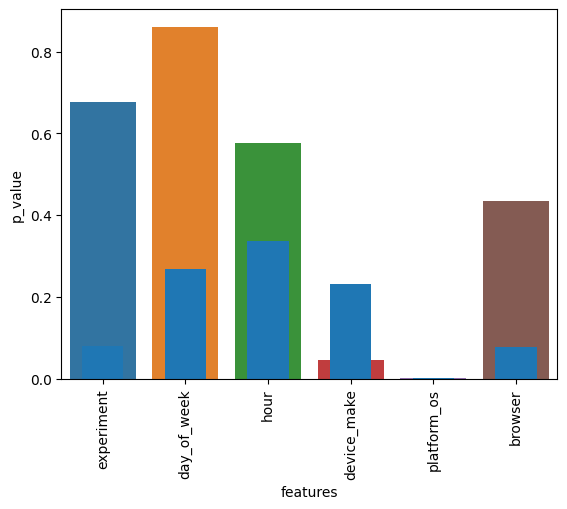

experiment     0.080613
day_of_week    0.267475
hour           0.338154
device_make    0.232371
platform_os    0.003095
browser        0.078292
dtype: float64

In [120]:
#feature importance in decision
decision_tree.get_feature_impo()

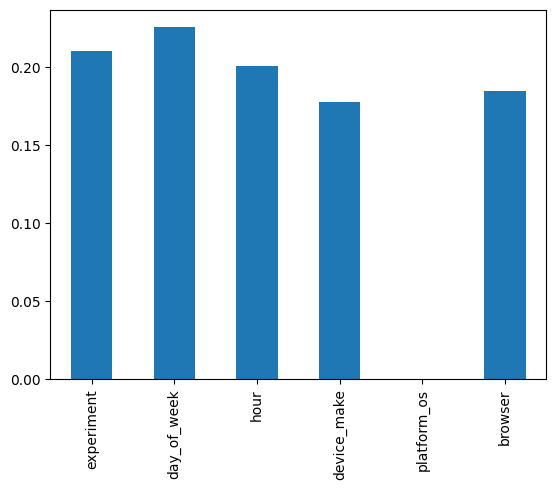

experiment     0.210564
day_of_week    0.225493
hour           0.201052
device_make    0.177933
platform_os    0.000000
browser        0.184958
dtype: float32

In [121]:
#feature importance in logistic regression
xg_boost.get_feature_impo()

In [122]:
from sklearn import model_selection

def eff_models(model, train_data, Y_train, kfold):
    scoring = ["accuracy","roc_auc","neg_log_loss","r2"] 

    eff_models = pd.DataFrame()
    eff_models["model"] = model
    for scor in scoring:
        score = []
        for mod in model:
           
            result = model_selection.cross_val_score(estimator= mod, X=train_data, y=Y_train,cv=kfold,scoring=scor )
            score.append(result.mean())
            
        eff_models[scor] =pd.Series(score)
        
    return eff_models

In [123]:

error_metrics(model=[log_model.model,decision_tree.model,xg_boost.model],train_data = X_train, Y_targ = Y_train, kfold=k_fold)

NameError: name 'error_metrics' is not defined

In [124]:
pred = log_model.get_predicate( X_val)

pre = pd.DataFrame()
pre["predicate"]=pred
pre["actual"] = Y_train

corr_mat = pre.corr()
top_corr_features = corr_mat.index
plt.figure(figsize=(10,10))
#plot heat map
sns.heatmap(pre[top_corr_features].corr(), annot= True)

log_model.get_eff_model(X_val,Y_val,k_fold)

,model,accuracy,roc_auc,neg_log_loss,r2,neg_mean_squared_error,neg_mean_absolute_error
0,Logistic regression,0.56498,0.578907,-0.687562,-0.751274,-0.43502,-0.43502


In [125]:
pred = decision_tree.get_predicate( X_val)

pre = pd.DataFrame()
pre["predicate"]=pred
pre["actual"] = Y_train

corr_mat = pre.corr()
top_corr_features = corr_mat.index
plt.figure(figsize=(10,10))
#plot heat map
sns.heatmap(pre[top_corr_features].corr(), annot= True)

decision_tree.get_eff_model(X_val,Y_val,k_fold)

,model,accuracy,roc_auc,neg_log_loss,r2,neg_mean_squared_error,neg_mean_absolute_error
0,Decission Tree,0.544571,0.532518,-13.4684,-0.882698,-0.475755,-0.479673


In [126]:
pred = xg_boost.get_predicate( X_val)

pre = pd.DataFrame()
pre["predicate"]=pred
pre["actual"] = Y_train

corr_mat = pre.corr()
top_corr_features = corr_mat.index
plt.figure(figsize=(10,10))
#plot heat map
sns.heatmap(pre[top_corr_features].corr(), annot= True)

xg_boost.get_eff_model(X_val,Y_val,k_fold)

[10:19:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:19:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:19:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:19:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,model,accuracy,roc_auc,neg_log_loss,r2,neg_mean_squared_error,neg_mean_absolute_error
0,XG_Boost,0.504163,0.482352,-1.145996,-0.995726,-0.495837,-0.495837


In [127]:
from scripts.data_manipulator import get_group, get_answered

ModuleNotFoundError: No module named 'scripts'